In [1]:
!pip install nibabel scikit-image opencv-python headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
#import libraries
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import filters, morphology, measure
from scipy.ndimage import binary_fill_holes, binary_dilation, label, generate_binary_structure

In [3]:
#utility function
def load_nifti(path):
    """ Load a NIfTI file and return iamge data, affine, and header."""
    img = nib.load(path)
    return img.get_fdata(), img.affine, img.header

def save_nifti(data, affine, header, path):
    """Save image data as NIfTI file"""
    nib.save(nib.Nifti1Image(data.astype(np.uint8), affine, header), path)

In [4]:
#task1.1: bone segmentation
def normalize(volume):
    volume = np.clip(volume, -1000, 2000)
    return (volume - np.min(volume)) / (np.max(volume) - np.min(volume))

def segment_bone(volume):
    threshold = filters.threshold_otsu(volume)
    binary = volume > threshold
    binary = morphology.remove_small_objects(binary, min_size=500)
    return binary_fill_holes(binary).astype(np.uint8)

def isolate_femur_tibia(binary_mask):
    labels, _ = label(binary_mask)
    props = measure.regionprops(labels)
    largest = sorted(props, key=lambda x: x.area, reverse=True)[:2]
    output_mask = np.zeros_like(binary_mask)
    for region in largest:
        output_mask[labels == region.label] = 1
    return output_mask

In [5]:
#task1.2: Contour Expansion
def calculate_voxel_radius(spacing, distance_mm):
    return [int(np.ceil(distance_mm / sp)) for sp in spacing]

def expand_mask(mask, spacing, distance_mm):
    iterations = max(calculate_voxel_radius(spacing, distance_mm))
    struct = generate_binary_structure(3, 1)
    return binary_dilation(mask, structure=struct, iterations=iterations).astype(np.uint8)


In [6]:
# task1.3: Ranomized Mask

def generate_random_mask_between(original_mask, expanded_mask, variation_strength=0.3):
    shell = (expanded_mask > original_mask).astype(np.uint8)
    noise = (np.random.rand(*shell.shape) < variation_strength).astype(np.uint8)
    return (original_mask + shell * noise).clip(0, 1).astype(np.uint8)


In [7]:
#task1.4: landmark detection
def find_medial_lateral_lowest(mask):
    coords = np.argwhere(mask > 0)
    if coords.size == 0:
        return None, None
    z_max = np.max(coords[:, 2])
    lowest = coords[coords[:, 2] == z_max]
    medial = lowest[np.argmin(lowest[:, 0])]
    lateral = lowest[np.argmax(lowest[:, 0])]
    return medial, lateral

In [8]:
# visualization helpers


def visualize_landmarks(volume, mask, medial, lateral, title):
    slice_idx = int(medial[2])
    base = volume[:, :, slice_idx]
    mask_slice = mask[:, :, slice_idx]
    plt.figure(figsize=(6, 6))
    plt.imshow(base, cmap='gray')
    plt.contour(mask_slice, levels=[0.5], colors='cyan')
    plt.plot(medial[1], medial[0], 'go', label='Medial')
    plt.plot(lateral[1], lateral[0], 'ro', label='Lateral')
    plt.title(f"{title} – Slice Z={slice_idx}")
    plt.legend()
    plt.axis('off')
    plt.show()

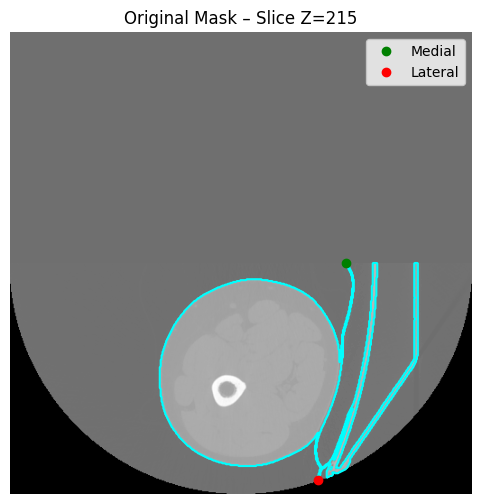

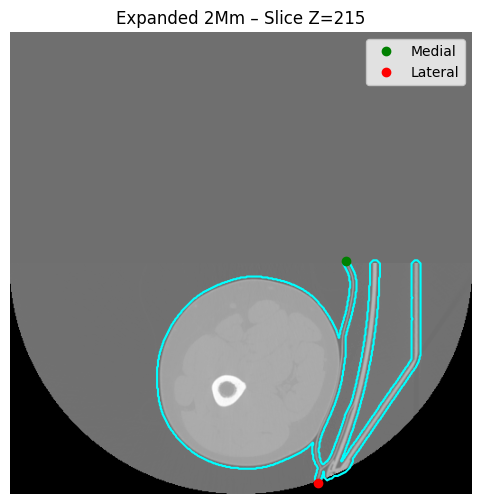

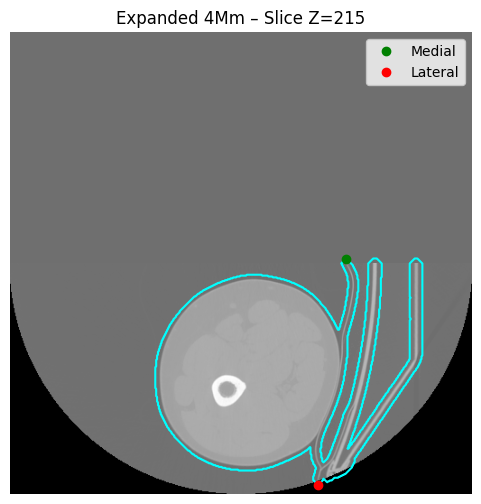

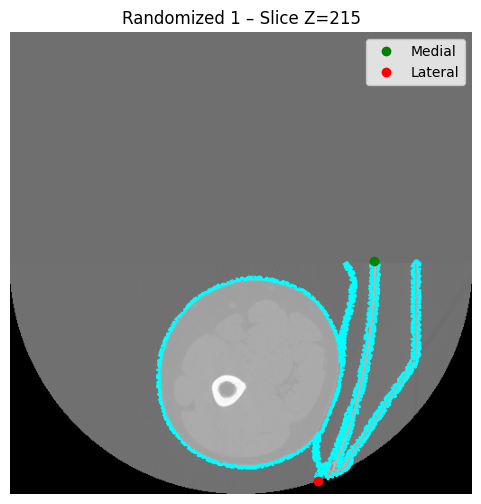

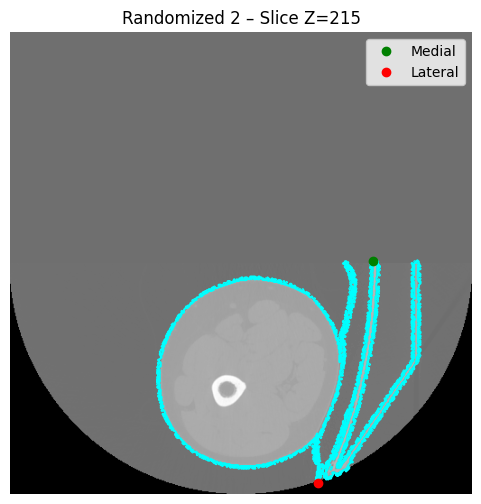

In [9]:

def main():
    input_ct = "/kaggle/input/3702-left-knee/3702_left_knee.nii"
    out_dir = "/kaggle/working/results/masks"
    os.makedirs(out_dir, exist_ok=True)

    # Load and segment
    vol, aff, hdr = load_nifti(input_ct)
    norm_vol = normalize(vol)
    bone_mask = isolate_femur_tibia(segment_bone(norm_vol))
    save_nifti(bone_mask, aff, hdr, os.path.join(out_dir, "original_mask.nii.gz"))

    # Expand 2mm & 4mm
    spacing = hdr.get_zooms()[:3]
    for mm in [2, 4]:
        expanded = expand_mask(bone_mask, spacing, mm)
        save_nifti(expanded, aff, hdr, os.path.join(out_dir, f"expanded_{mm}mm.nii.gz"))

    # Randomized masks
    exp2 = expand_mask(bone_mask, spacing, 2)
    for i in [1, 2]:
        rand = generate_random_mask_between(bone_mask, exp2, variation_strength=0.35)
        save_nifti(rand, aff, hdr, os.path.join(out_dir, f"randomized_{i}.nii.gz"))

    # Landmark extraction
    masks = ["original_mask", "expanded_2mm", "expanded_4mm", "randomized_1", "randomized_2"]
    for name in masks:
        mask, _, _ = load_nifti(os.path.join(out_dir, f"{name}.nii.gz"))
        medial, lateral = find_medial_lateral_lowest(mask)
        if medial is not None:
            visualize_landmarks(vol, mask, medial, lateral, name.replace("_", " ").title())

if __name__ == "__main__":
    main()
